<a href="https://colab.research.google.com/github/cisco08/2018-ORANGE-FINANCIAL-BIG-DATA-top9/blob/master/contrib/colab/mnist-training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PyTorch/TPU MNIST Demo

This colab example corresponds to the implementation under [test_train_mp_mnist.py](https://github.com/pytorch/xla/blob/master/test/test_train_mp_mnist.py).

<h3>  &nbsp;&nbsp;Use Colab Cloud TPU&nbsp;&nbsp; <a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a></h3>

* On the main menu, click Runtime and select **Change runtime type**. Set "TPU" as the hardware accelerator.
* The cell below makes sure you have access to a TPU on Colab.


In [31]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

### [RUNME] Install Colab TPU compatible PyTorch/TPU wheels and dependencies

In [26]:
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl

  Using cached https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl (149.9 MB)


### Only run the below commented cell if you would like a nightly release

In [30]:
# VERSION = "20200516"  #@param ["1.5" , "20200516", "nightly"]
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --version $VERSION

### Define Parameters and Helpers, and start Training


In [5]:
# Result Visualization Helper
import math
from matplotlib import pyplot as plt

M, N = 4, 6
RESULT_IMG_PATH = '/tmp/test_result.png'

def plot_results(images, labels, preds):
  images, labels, preds = images[:M*N], labels[:M*N], preds[:M*N]
  inv_norm = transforms.Normalize((-0.1307/0.3081,), (1/0.3081,))

  num_images = images.shape[0]
  fig, axes = plt.subplots(M, N, figsize=(11, 9))
  fig.suptitle('Correct / Predicted Labels (Red text for incorrect ones)')

  for i, ax in enumerate(fig.axes):
    ax.axis('off')
    if i >= num_images:
      continue
    img, label, prediction = images[i], labels[i], preds[i]
    img = inv_norm(img)
    img = img.squeeze() # [1,Y,X] -> [Y,X]
    label, prediction = label.item(), prediction.item()
    if label == prediction:
      ax.set_title(u'\u2713', color='blue', fontsize=22)
    else:
      ax.set_title(
          'X {}/{}'.format(label, prediction), color='red')
    ax.imshow(img)
  plt.savefig(RESULT_IMG_PATH, transparent=True)

In [33]:
# Define Parameters
FLAGS = {}
FLAGS['datadir'] = "/tmp/mnist"
FLAGS['batch_size'] = 128
FLAGS['num_workers'] = 4
FLAGS['learning_rate'] = 0.01
FLAGS['momentum'] = 0.5
FLAGS['num_epochs'] = 10
FLAGS['num_cores'] = 8
FLAGS['log_steps'] = 20
FLAGS['metrics_debug'] = False

In [34]:
import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.debug.metrics as met
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.utils.utils as xu
from torchvision import datasets, transforms


SERIAL_EXEC = xmp.MpSerialExecutor()

class MNIST(nn.Module):

  def __init__(self):
    super(MNIST, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.bn1 = nn.BatchNorm2d(10)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.bn2 = nn.BatchNorm2d(20)
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = self.bn1(x)
    x = F.relu(F.max_pool2d(self.conv2(x), 2))
    x = self.bn2(x)
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

# Only instantiate model weights once in memory.
WRAPPED_MODEL = xmp.MpModelWrapper(MNIST())

def train_mnist():
  torch.manual_seed(1)
  
  def get_dataset():
    norm = transforms.Normalize((0.1307,), (0.3081,))
    train_dataset = datasets.MNIST(
        FLAGS['datadir'],
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor(), norm]))
    test_dataset = datasets.MNIST(
        FLAGS['datadir'],
        train=False,
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor(), norm]))
    
    return train_dataset, test_dataset
  
  # Using the serial executor avoids multiple processes to
  # download the same data.
  train_dataset, test_dataset = SERIAL_EXEC.run(get_dataset)

  train_sampler = torch.utils.data.distributed.DistributedSampler(
    train_dataset,
    num_replicas=xm.xrt_world_size(),
    rank=xm.get_ordinal(),
    shuffle=True)
  train_loader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size=FLAGS['batch_size'],
      sampler=train_sampler,
      num_workers=FLAGS['num_workers'],
      drop_last=True)
  test_loader = torch.utils.data.DataLoader(
      test_dataset,
      batch_size=FLAGS['batch_size'],
      shuffle=False,
      num_workers=FLAGS['num_workers'],
      drop_last=True)

  # Scale learning rate to world size
  lr = FLAGS['learning_rate'] * xm.xrt_world_size()

  # Get loss function, optimizer, and model
  device = xm.xla_device()
  model = WRAPPED_MODEL.to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=FLAGS['momentum'])
  loss_fn = nn.NLLLoss()

  def train_loop_fn(loader):
    tracker = xm.RateTracker()
    model.train()
    for x, (data, target) in enumerate(loader):
      optimizer.zero_grad()
      output = model(data)
      loss = loss_fn(output, target)
      loss.backward()
      xm.optimizer_step(optimizer)
      tracker.add(FLAGS['batch_size'])
      if x % FLAGS['log_steps'] == 0:
        print('[xla:{}]({}) Loss={:.5f} Rate={:.2f} GlobalRate={:.2f} Time={}'.format(
            xm.get_ordinal(), x, loss.item(), tracker.rate(),
            tracker.global_rate(), time.asctime()), flush=True)

  def test_loop_fn(loader):
    total_samples = 0
    correct = 0
    model.eval()
    data, pred, target = None, None, None
    for data, target in loader:
      output = model(data)
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(target.view_as(pred)).sum().item()
      total_samples += data.size()[0]

    accuracy = 100.0 * correct / total_samples
    print('[xla:{}] Accuracy={:.2f}%'.format(
        xm.get_ordinal(), accuracy), flush=True)
    return accuracy, data, pred, target

  # Train and eval loops
  accuracy = 0.0
  data, pred, target = None, None, None
  for epoch in range(1, FLAGS['num_epochs'] + 1):
    para_loader = pl.ParallelLoader(train_loader, [device])
    train_loop_fn(para_loader.per_device_loader(device))
    xm.master_print("Finished training epoch {}".format(epoch))

    para_loader = pl.ParallelLoader(test_loader, [device])
    accuracy, data, pred, target  = test_loop_fn(para_loader.per_device_loader(device))
    if FLAGS['metrics_debug']:
      xm.master_print(met.metrics_report(), flush=True)

  return accuracy, data, pred, target

In [8]:
# Start training processes
def _mp_fn(rank, flags):
  global FLAGS
  FLAGS = flags
  torch.set_default_tensor_type('torch.FloatTensor')
  accuracy, data, pred, target = train_mnist()
  if rank == 0:
    # Retrieve tensors that are on TPU core 0 and plot.
    plot_results(data.cpu(), pred.cpu(), target.cpu())

xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=FLAGS['num_cores'],
          start_method='fork')

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /tmp/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /tmp/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /tmp/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /tmp/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid poten

[xla:0](0) Loss=2.35091 Rate=82.70 GlobalRate=82.70 Time=Wed Sep  8 02:40:27 2021


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid poten

[xla:1](0) Loss=2.35921 Rate=316.02 GlobalRate=315.99 Time=Wed Sep  8 02:40:33 2021


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid poten

[xla:3](0) Loss=2.32649 Rate=308.56 GlobalRate=308.55 Time=Wed Sep  8 02:40:34 2021


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid poten

[xla:4](0) Loss=2.30819 Rate=271.84 GlobalRate=271.83 Time=Wed Sep  8 02:40:36 2021


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid poten

[xla:2](0) Loss=2.35578 Rate=173.58 GlobalRate=173.57 Time=Wed Sep  8 02:40:36 2021
[xla:5](0) Loss=2.36828 Rate=288.46 GlobalRate=288.44 Time=Wed Sep  8 02:40:37 2021


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid poten

[xla:6](0) Loss=2.35085 Rate=312.65 GlobalRate=312.62 Time=Wed Sep  8 02:40:41 2021


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid poten

[xla:7](0) Loss=2.32070 Rate=264.13 GlobalRate=264.11 Time=Wed Sep  8 02:40:43 2021
[xla:6](20) Loss=0.31652 Rate=395.13 GlobalRate=440.88 Time=Wed Sep  8 02:40:46 2021
[xla:1](20) Loss=0.33523 Rate=237.19 GlobalRate=188.37 Time=Wed Sep  8 02:40:46 2021
[xla:7](20) Loss=0.39114 Rate=542.37 GlobalRate=671.71 Time=Wed Sep  8 02:40:46 2021
[xla:2](20) Loss=0.43074 Rate=222.36 GlobalRate=249.32 Time=Wed Sep  8 02:40:46 2021
[xla:3](20) Loss=0.41579 Rate=244.87 GlobalRate=205.78 Time=Wed Sep  8 02:40:46 2021
[xla:4](20) Loss=0.42410 Rate=251.40 GlobalRate=239.20 Time=Wed Sep  8 02:40:46 2021
[xla:0](20) Loss=0.43566 Rate=110.59 GlobalRate=125.81 Time=Wed Sep  8 02:40:46 2021
[xla:5](20) Loss=0.45230 Rate=278.83 GlobalRate=273.14 Time=Wed Sep  8 02:40:47 2021
[xla:0](40) Loss=0.21824 Rate=660.64 GlobalRate=219.98 Time=Wed Sep  8 02:40:49 2021
[xla:6](40) Loss=0.20704 Rate=717.81 GlobalRate=593.60 Time=Wed Sep  8 02:40:49 2021
[xla:5](40) Loss=0.16844 Rate=679.62 GlobalRate=418.33 Time=Wed Se

## Visualize Predictions

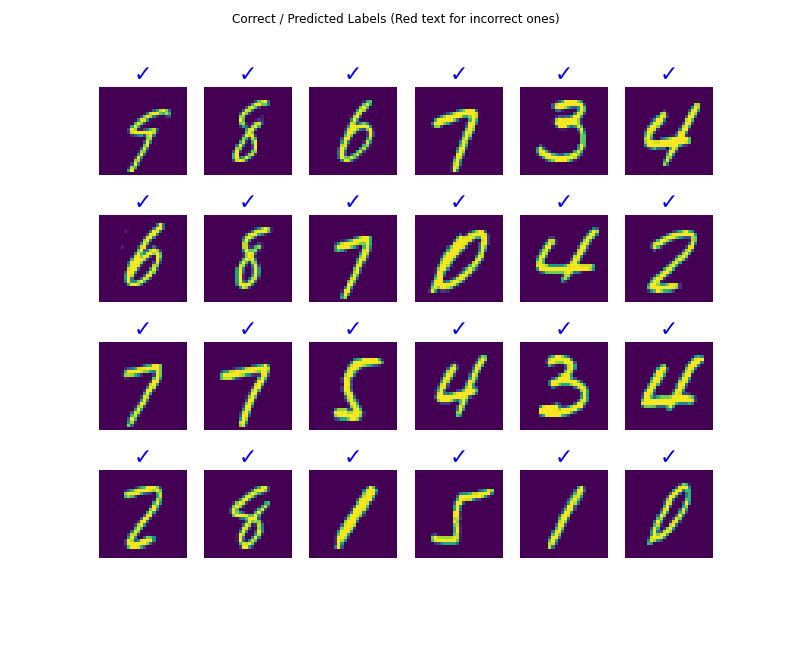

In [10]:
from google.colab.patches import cv2_imshow
import cv2
img = cv2.imread(RESULT_IMG_PATH, cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

In [9]:
!https://github.com/Harrypotterrrr/DVD-GAN

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [12]:
!git clone https://github.com/Harrypotterrrr/DVD-GAN

Cloning into 'DVD-GAN'...
remote: Enumerating objects: 481, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 481 (delta 32), reused 41 (delta 20), pack-reused 422
Receiving objects: 100% (481/481), 113.94 KiB | 2.48 MiB/s, done.
Resolving deltas: 100% (298/298), done.


In [24]:
%cd /content/DVD-GAN
!bash scripts/data_prepare.sh

/content/DVD-GAN
using only one class: PlayingViolin


In [17]:
!bash /content/DVD-GAN/scripts/download_annotations.sh /UCF101

Archive:  UCF101TrainTestSplits-RecognitionTask.zip
   creating: ucfTrainTestlist/
  inflating: ucfTrainTestlist/classInd.txt  
  inflating: ucfTrainTestlist/testlist01.txt  
  inflating: ucfTrainTestlist/testlist02.txt  
  inflating: ucfTrainTestlist/testlist03.txt  
  inflating: ucfTrainTestlist/trainlist01.txt  
  inflating: ucfTrainTestlist/trainlist02.txt  
  inflating: ucfTrainTestlist/trainlist03.txt  


In [ ]:
!scripts/train_model.sh GCP /

python3.7 main.py --adv_loss hinge --parallel True --gpus 0 1 2 3 --num_workers 16 --use_tensorboard True --ds_chn 64 --dt_chn 64 --g_chn 64 --n_frames 8 --k_sample 4 --batch_size 40 --n_class 1 --root_path //UCF101 --annotation_path annotations/ucf101_01.json --log_path ~/outputs/logs --model_save_path ~/outputs/models --sample_path ~/outputs/samples
model = dvd-gan
adv_loss = hinge
imsize = 128
g_num = 5
g_chn = 64
z_dim = 120
ds_chn = 64
dt_chn = 64
g_conv_dim = 64
d_conv_dim = 64
lambda_gp = 10
lr_schr = const
version = 
total_epoch = 100000
d_iters = 1
g_iters = 1
batch_size = 40
num_workers = 16
g_lr = 5e-05
d_lr = 5e-05
lr_decay = 0.9999
beta1 = 0.0
beta2 = 0.9
pretrained_model = None
train = True
parallel = True
gpus = ['0', '1', '2', '3']
dataset = ucf101
use_tensorboard = True
n_class = 1
k_sample = 4
n_frames = 8
test_batch_size = 8
image_path = ./data
log_path = ~/outputs/logs
model_save_path = ~/outputs/models
sample_path = ~/outputs/samples
log_epoch = 1
sample_epoch = 20

In [40]:
!pip install tensorboardX==1.8

     |████████████████████████████████| 216 kB 5.1 MB/s 


In [37]:
torch

<module 'torch' from '/usr/local/lib/python3.7/dist-packages/torch/__init__.py'>